<font size = "6"> Fordham Sports Analytics Society Big Data Bowl 2023 - Model Creation </font>

<font size = "4"> Build regression model to determine the distance of an individual rusher at the end of QB "Possession". </font>

- Authors:  Peter Majors, Chris Orlando, Jack Townsend, and Etienne Busnel
- Kaggle:  https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/overview (Resources)
- Our Github:  https://github.com/peterlmajors/FSAS_BigDataBowl_2023 (Up-To-Date Code)

In [1]:
#Import Relevant Packages

#Data Manipulation
import pandas as pd
import numpy as np
from numpy import mean, std
import math

#Data Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
import seaborn as sns 
import plotly.graph_objects as go

#SKLearn
import sklearn
from sklearn.metrics import get_scorer_names, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

#XGBoost
import xgboost as xgb
from xgboost import XGBRegressor, cv, plot_importance

#Statistics
from scipy.stats import pearsonr, spearmanr, uniform, randint

#Notebook Settings
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
#Import Model Ready Data
df = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/df_model.csv")

#Create Feature List
df_features = ['s_rusher_ff_imm_box', 'rusher_dist_from_qb_diff_beg_end_imm_zone', 'diff_btw_rusher_dir_blocker_o_ff_in_imm', 'blocker_o_diff_beg_end_imm_zone', 
               'time_rusher_in_imm_zone', 'time_in_imm_zone_after_out', 'qb_pressure_sack_percent', 'rusher_avg_dist_from_qb_end_poss', 'pff_beatenByDefender',
               'dropBack_traditional', 'dropBack_scramble', 'blockType_PP', 'blockType_PA', 'blockType_PT', 'blockType_SW', 'blockType_CL', 'blockType_PR', 'blockType_UP']

#Continuous Features
df_features_cont = ['s_rusher_ff_imm_box', 'rusher_dist_from_qb_diff_beg_end_imm_zone', 'diff_btw_rusher_dir_blocker_o_ff_in_imm', 'blocker_o_diff_beg_end_imm_zone', 
                    'time_rusher_in_imm_zone', 'time_in_imm_zone_after_out', 'qb_pressure_sack_percent', 'rusher_avg_dist_from_qb_end_poss']

#Non-Continuous Features  
df_features_non_cont = ['pff_beatenByDefender', 'dropBack_traditional', 'dropBack_scramble', 'blockType_PP', 'blockType_PA', 'blockType_PT', 'blockType_SW', 
                        'blockType_CL', 'blockType_PR', 'blockType_UP'] 

#Target Variable
df_target = ['rusher_dist_from_qb_end_poss']

<font size = "5"> Data Preprocessing (Null Values and One Hot Encoding) </font>

In [3]:
#Null Values
#Fill Time left In Immediate Zone Once Out As 0 If The Rusher Doesn't Re-Enter Or Never Leaves
df['time_in_imm_zone_after_out'] = df['time_in_imm_zone_after_out'].fillna(0)

#Fill Pressure Sack Percent To Mean Where Measurements Are Null (Decimals)
avg_qb_pressure_sack_percent = float(df['qb_pressure_sack_percent'].mean())
df['qb_pressure_sack_percent'] = df['qb_pressure_sack_percent'].fillna(avg_qb_pressure_sack_percent)

In [4]:
#One Hot Encoding For Categorical Data

#Remove Plays With Rollouts To Either Direction and Deisgned Runs
df = df.loc[(df.dropBackType == 'TRADITIONAL') | (df.dropBackType == 'SCRAMBLE')]

#Binary Encoding For Drop Back Type
df['dropBack_traditional'] = np.where(df.dropBackType == 'TRADITIONAL', 1, 0)
df['dropBack_scramble'] = np.where(df.dropBackType == 'SCRAMBLE', 1, 0)

#Binary Encoding For Block Type
df['blockType_PP'] = np.where(df.pff_blockType == 'PP', 1, 0)
df['blockType_PA'] = np.where(df.pff_blockType == 'PA', 1, 0)
df['blockType_PT'] = np.where(df.pff_blockType == 'PT', 1, 0)
df['blockType_SW'] = np.where(df.pff_blockType == 'SW', 1, 0)
df['blockType_CL'] = np.where(df.pff_blockType == 'CL', 1, 0)
df['blockType_PR'] = np.where(df.pff_blockType == 'PR', 1, 0)
df['blockType_UP'] = np.where(df.pff_blockType == 'UP', 1, 0)

[Text(0.5, 1.0, 'Correlation Matrix of Continuous Variables')]

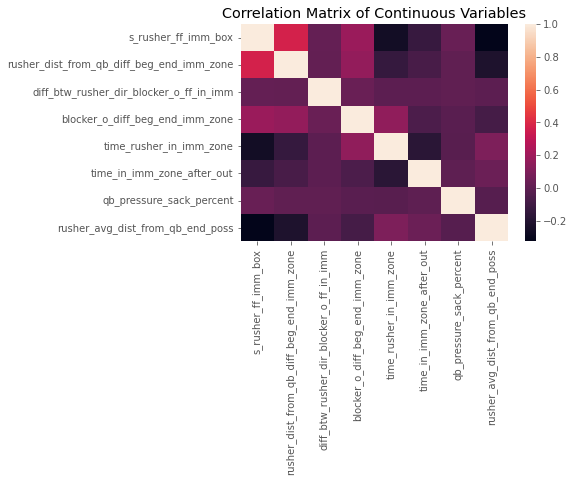

In [5]:
#Look At A Heatmap of Continuous Variables
sns.heatmap(df[df_features_cont].corr()).set(title = "Correlation Matrix of Continuous Variables")

<font size = "5"> Explore Relationships Between Features And Target Variable </font>

In [6]:
#Create Tackles & Guards and Centers DataFrames
df_t = df.loc[(df.pff_positionLinedUp == 'LT') | (df.pff_positionLinedUp == 'RT')]
df_gc = df.loc[(df.pff_positionLinedUp == 'C') | (df.pff_positionLinedUp == 'LG') | (df.pff_positionLinedUp == 'RG')]

In [7]:
#Categorical Values To Gropupby
# df.groupby('dropBackType')['rusher_dist_from_qb_end_poss'].mean()

#Cotinuous Correlations
# spearmanr(df.s_rusher_ff_imm_box, df.rusher_dist_from_qb_end_poss)

Continuous Values To Correlate (Spearman R) And Categorical Ones To Compare

 Feature 1: 's_rusher_ff_imm_box' = -.22 (Faster Rusher, Less Distance To QB)
   - Alot For Tackles (-.36), Not So Much For Guards and Centers (-.14)

 Feature 2: 'rusher_dist_from_qb_diff_beg_end_imm_zone' = - .72 (More Distance Covered, Less Distance To QB)
   - More For Tackles (-.78) Than Guards and Centers (-.69)

 Feature 3: 'diff_btw_rusher_dir_blocker_o_ff_in_imm' = .02 (More Difference, Less Distance)
  - Bad In Both Subsets
  
 Feature 4: 'blocker_o_diff_beg_end_imm_zone' = -.10 (More Turn of Shoulders, Less Distance)
  - Slightly More For Tackles (-.14) Than Guards and Centers (-.05) But P-Value Too High

 Feature 5: 'time_rusher_in_imm_zone' = .03 (More Time, Less Distance)
  - Seems Bad In Both Subsets

 Feature 6: 'time_in_imm_zone_after_out' = .04 (More Time, Less Distance)
  - Seems Bad In Both Subsets

 Feature 7: 'qb_pressure_sack_percent' = -.01 (Higher Rate Of Sacked When Pressured, Less Distance)
  - Seems Bad In Both Subsets

 Feature 8: 'rusher_avg_dist_from_qb_end_poss' = .20 (Higher Average, Higher On That Play)
  - Slightly More For Tackles (.22) Than Guards and Centers (.17)

 Feature 9: 'pff_beatenByDefender (0 = 5.3, 1 = 3.5 Yards)
  - Matters About The Same For Gaurds and Centers As Tackles

 Feature 10 (2 Columns): 'dropBackType' (Between 4 and 10 Yards)
  - Seems To Matter The Same For Gaurds and Centers As Tackles

 Feature 11 (7 Columns): 'pff_blockType" (Between 8.53 And 4.71 Yards)
  - Seems To Matter For Both Subsets


<font size = '5' > Tackles Model Scaling and Fitting </font>

In [8]:
#Scaling On Tackles Data

#Standardize Continuous Values Around The Mean of 0
scaler = StandardScaler()
df_s_t = scaler.fit_transform(df_t[df_features_cont])

#Turn It Back Into A Data Frame And Return Column Names
df_s_t = pd.DataFrame(df_s_t)
df_s_t.columns = df_features_cont

df_s_t = pd.concat([df_t[df_features_non_cont].reset_index(drop = True), df_s_t], axis = 1)

In [37]:
df_t_weeks = pd.DataFrame(df_t.reset_index(drop = True)['week'])
df_t_weeks = df_t_weeks[df_t_weeks.week < 5]
df_t_weeks.shape

(7551, 1)

In [16]:
df_t.s_rusher_ff_imm_box.mean()

3.8399418808206707

In [35]:
df_s_t[df_features]

,s_rusher_ff_imm_box,rusher_dist_from_qb_diff_beg_end_imm_zone,diff_btw_rusher_dir_blocker_o_ff_in_imm,blocker_o_diff_beg_end_imm_zone,time_rusher_in_imm_zone,time_in_imm_zone_after_out,qb_pressure_sack_percent,rusher_avg_dist_from_qb_end_poss,pff_beatenByDefender,dropBack_traditional,dropBack_scramble,blockType_PP,blockType_PA,blockType_PT,blockType_SW,blockType_CL,blockType_PR,blockType_UP
0,0.834468,0.058422,0.457314,-0.620379,-0.043694,-0.17833,-0.380170,-0.395161,0.0,1,0,1,0,0,0,0,0,0
1,-1.134117,0.215780,-0.670845,0.963000,-0.159463,-0.17833,-0.380170,-0.521429,0.0,1,0,1,0,0,0,0,0,0
2,1.174717,-0.481690,0.465890,-0.724928,-1.664458,-0.17833,-0.380170,-0.521429,0.0,1,0,1,0,0,0,0,0,0
3,1.239527,-0.163214,-1.101807,-0.885199,-1.432920,-0.17833,-0.380170,-0.804563,0.0,1,0,1,0,0,0,0,0,0
4,0.688647,-0.417719,0.355929,-0.909161,-1.548689,-0.17833,-0.380170,-0.395161,0.0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14276,0.437511,0.795188,-1.118163,-0.825408,0.419381,-0.17833,0.564775,-0.973768,0.0,1,0,1,0,0,0,0,0,0
14277,0.032452,-0.349358,-1.024926,-0.584550,-0.043694,-0.17833,0.564775,-1.117831,0.0,1,0,1,0,0,0,0,0,0
14278,0.688647,1.496283,-1.110629,-0.748551,-0.275232,-0.17833,0.564775,0.586213,0.0,1,0,1,0,0,0,0,0,0
14279,-0.494125,0.336041,-1.142912,-0.173701,-0.506769,-0.17833,0.564775,-1.117831,0.0,1,0,0,0,0,1,0,0,0


In [80]:
#Prepare Features and Test/Train

#Import The Standardized Tackle Data
X_t = df_s_t[df_features]
y_t = df_t[df_target]

#Split Data By First Half/Second Half Of The Weeks To Make Model Interpretable Among Other Metrics

#Find Plays For Weeks 1-4 and 5-8
df_t_weeks = pd.DataFrame(df_t['week'])
df_t_weeks_1_4 = df_t_weeks[df_t_weeks.week < 5]
df_t_weeks_5_8 = df_t_weeks[df_t_weeks.week > 4]

#Merge Onto The X and y to Make Training Data
X_train = pd.concat([df_t_weeks_1_4, X_t], axis = 1, join = 'inner')
y_train = pd.concat([df_t_weeks_1_4, y_t], axis = 1, join = 'inner')

#Merge Onto The X and y to Make Test Data
X_test = pd.concat([df_t_weeks_5_8, X_t], axis = 1, join = 'inner')
y_test = pd.concat([df_t_weeks_5_8, y_t], axis = 1, join = 'inner')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2620, 19) (7551, 2) (2489, 19) (6730, 2)


In [78]:
X_train

,week,s_rusher_ff_imm_box,rusher_dist_from_qb_diff_beg_end_imm_zone,diff_btw_rusher_dir_blocker_o_ff_in_imm,blocker_o_diff_beg_end_imm_zone,time_rusher_in_imm_zone,time_in_imm_zone_after_out,qb_pressure_sack_percent,rusher_avg_dist_from_qb_end_poss,pff_beatenByDefender,dropBack_traditional,dropBack_scramble,blockType_PP,blockType_PA,blockType_PT,blockType_SW,blockType_CL,blockType_PR,blockType_UP
1,1.0,-1.134117,0.215780,-0.670845,0.963000,-0.159463,-0.17833,-0.380170,-0.521429,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.688647,-0.417719,0.355929,-0.909161,-1.548689,-0.17833,-0.380170,-0.395161,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.907379,1.019583,0.523107,2.861157,-0.391000,-0.17833,-0.380170,-0.395161,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.255729,0.843674,-1.061743,0.497899,1.229763,-0.17833,-0.380170,0.713439,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,0.024351,1.492112,-0.959133,0.881056,0.419381,-0.17833,-0.380170,0.839522,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14276,NaN,0.437511,0.795188,-1.118163,-0.825408,0.419381,-0.17833,0.564775,-0.973768,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14277,NaN,0.032452,-0.349358,-1.024926,-0.584550,-0.043694,-0.17833,0.564775,-1.117831,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14278,NaN,0.688647,1.496283,-1.110629,-0.748551,-0.275232,-0.17833,0.564775,0.586213,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14279,NaN,-0.494125,0.336041,-1.142912,-0.173701,-0.506769,-0.17833,0.564775,-1.117831,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [74]:
df_t_weeks_1_4

,week
1,1
4,1
6,1
9,1
10,1
...,...
40132,1
40135,1
40136,1
40140,1


In [47]:
X_test.shape[0] / X_train.shape[0]

0.8912726791153489

In [ ]:
#Study Hyperparameters Using Cross Validation

#Assign Model
model_t = XGBRegressor(n_estimators= 75, max_depth=5, eta = .05, subsample = .6, colsample_bytree = .7)

#Utilize Cross Validation To Further Enhance Model
cv = RepeatedKFold(n_splits=10, n_repeats=8, random_state=1)
scores = cross_val_score(model_t, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error', n_jobs = -1, error_score = 'raise')

scores = abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [864]:
#Update The Model Based On Cross Validation Tests and Fit
model_t = XGBRegressor(objective = 'reg:squarederror', n_estimators= 75, max_depth = 5, eta = .05, subsample = .6, colsample_bytree = .4)
model_t.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)]) #Check For Overfitting

[0]	validation_0-rmse:4.61545	validation_1-rmse:4.73615
[1]	validation_0-rmse:4.44241	validation_1-rmse:4.56052
[2]	validation_0-rmse:4.27967	validation_1-rmse:4.39636
[3]	validation_0-rmse:4.10250	validation_1-rmse:4.21443
[4]	validation_0-rmse:3.95747	validation_1-rmse:4.06662
[5]	validation_0-rmse:3.82121	validation_1-rmse:3.92932
[6]	validation_0-rmse:3.66913	validation_1-rmse:3.77385
[7]	validation_0-rmse:3.54826	validation_1-rmse:3.65010
[8]	validation_0-rmse:3.44341	validation_1-rmse:3.54565
[9]	validation_0-rmse:3.33656	validation_1-rmse:3.43748
[10]	validation_0-rmse:3.23843	validation_1-rmse:3.33674
[11]	validation_0-rmse:3.14919	validation_1-rmse:3.24613
[12]	validation_0-rmse:3.03854	validation_1-rmse:3.13087
[13]	validation_0-rmse:2.95874	validation_1-rmse:3.04876
[14]	validation_0-rmse:2.85936	validation_1-rmse:2.94586
[15]	validation_0-rmse:2.76727	validation_1-rmse:2.84988
[16]	validation_0-rmse:2.70827	validation_1-rmse:2.79017
[17]	validation_0-rmse:2.62795	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [865]:
#Make Predictions On The Test Set
y_pred = model_t.predict(X_test)

#Calculate Mean Squared Error On Test Set
mse = mean_squared_error(y_test, y_pred)
r = spearmanr(y_pred, y_test)[0]
print(np.sqrt(mse), r)

1.742881033994972 0.7471249640605704


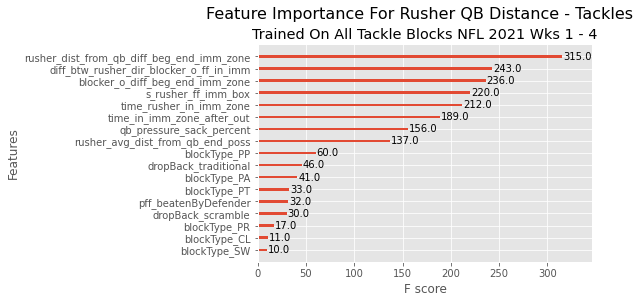

In [877]:
#Show Feature Importance
fig = plot_importance(model_t)
plt.title("Trained On All Tackle Blocks NFL 2021 Wks 1 - 4")
plt.suptitle('Feature Importance For Rusher QB Distance - Tackles', size = 16, y= 1.01)

plt.show()

<font size = '5' > Guards and Centers Model Scaling and Fitting </font>

In [ ]:
#Scaling On Guards and Centers Data

#Standardize Continuous Values Around The Mean of 0
scaler = StandardScaler()
df_s_gc = scaler.fit_transform(df_gc[df_features_cont])

#Turn It Back Into A Data Frame And Return Column Names
df_s_gc = pd.DataFrame(df_s_gc)
df_s_gc.columns = df_features_cont

df_s_gc = pd.concat([df_gc[df_features_non_cont].reset_index(drop = True), df_s_gc], axis = 1)

In [ ]:
#Study Hyperparameters Using Cross Validation

#Import The Standardized Tackle Data From Weeks 1 - 4
# df_s_gc 

#Assign Test and Train Features
X = df_s_gc[df_features]
y = df_gc[df_target]

#Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

#Assign Model
model_gc = XGBRegressor(objective = 'reg:linear', n_estimators= 50, max_depth=10, eta = .05, subsample = .8, colsample_bytree = .8)

#Utilize Cross Validation To Further Enhance Model
cv = RepeatedKFold(n_splits=10, n_repeats=8, random_state=1)
scores = cross_val_score(model_gc, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error', n_jobs = -1, error_score = 'raise')

scores = abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [ ]:
#Update The Model Based On Cross Validation Tests and Fit
model_gc = XGBRegressor(objective = 'reg:squarederror', n_estimators= 120, max_depth = 4, eta = .05, subsample = .6, colsample_bytree = .5)
model_gc.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)]) #Check For Overfitting

In [ ]:
#Make Predictions On The Test Set
y_pred = model_gc.predict(X_test)

#Calculate Mean Squared Error On Test Set
mse = mean_squared_error(y_test, y_pred)
r = spearmanr(y_pred, y_test)[0]
print(np.sqrt(mse), r)

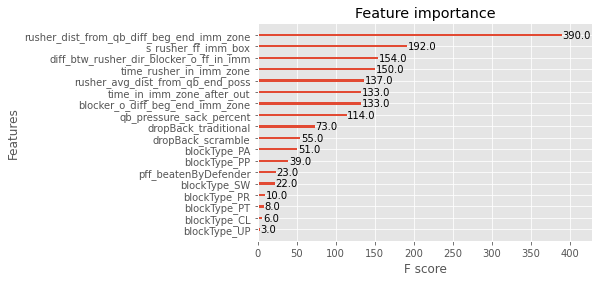

In [874]:
#Show Feature Importance
xgb.plot_importance(model_gc)
plt.show()

<font size = '5' > Use Model To Create Final Predictions </font>

In [ ]:
# df_t['pred_rusher_dist_from_qb_as_end_poss'] = 
pred_t = pd.DataFrame(model_t.predict(df_t[df_features])).reset_index(drop = True)

df_t = pd.concat([df_t, pred_t], axis = 1)
df_t

Fit The Models On The Main Data Frame

figure out feature stuff

figure out epa

look at distance and # of rushers (table)

box and whisker plot for model residuals

complete write up

moving immediate zone graphic